In [13]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time

import cv2
%matplotlib inline

In [14]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [15]:
data_dir = 'drive/MyDrive/AI_DATASET/EuroSAT/EuroSAT/'
print(os.listdir(data_dir))

['Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'AnnualCrop']


In [16]:
d = "cpu"
if torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: cuda:0


In [ ]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"AnnualCrop" : 0, "Forest": 1,"HerbaceousVegetation": 2,"Highway": 3,"Industrial":4,"Pasture":5,"PermanentCrop":6,"Residential":7,"River":8,"SeaLake":9}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))


501 157 126


In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

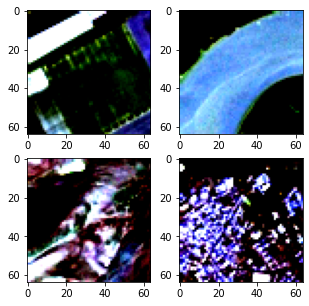

In [ ]:
plot_data_loader(data_loader_test,[2,2])

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights=None)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()


In [30]:
model.to(device)

num_epochs = 20
total_steps = len(data_loader_train)
t1 = time.time()
accuracies = []
losses = []
accuracies_v = []
losses_v = []

for epoch in range(num_epochs):
    ti = 0;
    total_correct = 0;
    tl = 0.0
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        tl+=loss.item()
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        ti+=total
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct+= (predicted == labels).sum()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, 
                          loss.item(),
                      (correct / total) * 100))
    # validation 
    total_correct_v = 0.0
    ti_v = 0
    tl_v = 0.0
    for _, data_v in enumerate(data_loader_val):
        images_v, labels_v = data_v[0].to(device), data_v[1].to(device)
        labels_v=torch.flatten(labels_v)
        outputs_v = model(images_v)
        loss_v = criterion(outputs_v,labels_v)
        valid_loss = loss_v.item() * labels_v.size(0)
        tl_v+=valid_loss
        # Validation accuracy
        total_v = labels_v.size(0)
        ti_v+=total_v
        _,predicted_v = torch.max(outputs_v.data, 1)
        correct_v = (predicted_v == labels_v).sum().item() 
        total_correct_v+= (predicted_v == labels_v).sum() 
    print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, float(tl_v)/ti_v, total_correct_v / ti_v*100.0))
    accuracies_v.append(total_correct_v / ti_v*100.0)    
    losses_v.append(float(tl_v)/ti_v)  
    accuracies.append(total_correct/ti*100.0)
    losses.append(float(tl)/ti)
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/20], Step [100/501], Train Loss: 0.9583, Train Accuracy: 68.75%
Epoch [1/20], Step [200/501], Train Loss: 1.0424, Train Accuracy: 68.75%
Epoch [1/20], Step [300/501], Train Loss: 0.6455, Train Accuracy: 68.75%
Epoch [1/20], Step [400/501], Train Loss: 0.5805, Train Accuracy: 81.25%
Epoch [1/20], Step [500/501], Train Loss: 1.2128, Train Accuracy: 53.12%
Epoch [1/20], Validation Loss: 0.7748, Validation Accuracy: 71.85%
Epoch [2/20], Step [100/501], Train Loss: 0.9004, Train Accuracy: 65.62%
Epoch [2/20], Step [200/501], Train Loss: 0.7398, Train Accuracy: 68.75%
Epoch [2/20], Step [300/501], Train Loss: 0.7537, Train Accuracy: 65.62%
Epoch [2/20], Step [400/501], Train Loss: 0.7186, Train Accuracy: 68.75%
Epoch [2/20], Step [500/501], Train Loss: 0.4202, Train Accuracy: 87.50%
Epoch [2/20], Validation Loss: 0.6766, Validation Accuracy: 74.97%
Epoch [3/20], Step [100/501], Train Loss: 1.1108, Train Accuracy: 62.50%
Epoch [3/20], Step [200/501], Train Loss: 0.8729, Train Accurac

In [31]:
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5004 test images: 73.1814548361311 %


In [32]:
acc_list = [i.item() for i in accuracies]

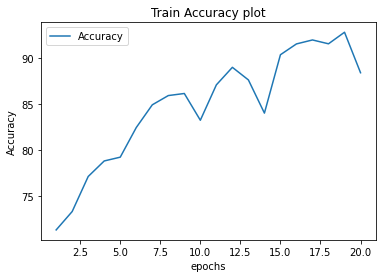

In [33]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list)
plt.legend(['Accuracy'])

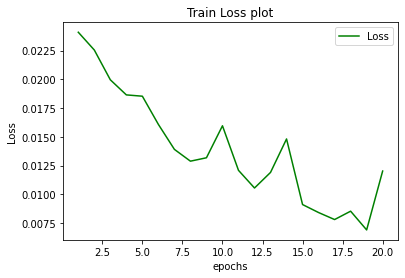

In [34]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Train Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])

In [35]:
acc_list_v = [i.item() for i in accuracies_v]

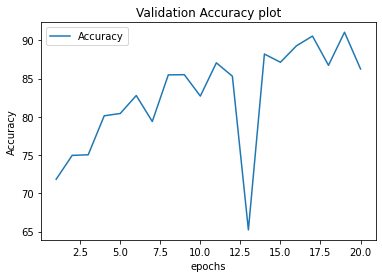

In [36]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list_v)
plt.legend(['Accuracy'])

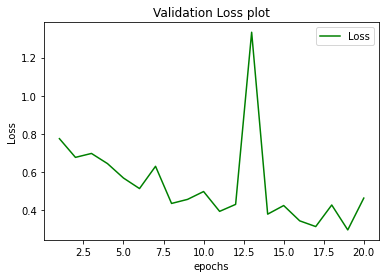

In [38]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Validation Loss plot')
plt.plot(range(1,num_epochs+1),losses_v,'g')
plt.legend(['Loss'])